# Практическая работа II - 1

## Задания

1. Скачать датасет [Nails segmentation](https://www.kaggle.com/vpapenko/nails-segmentation#1eecab90-1a92-43a7-b952-0204384e1fae.jpg). Составить список из пар (<имя изображения>, <маска>) для всех данных, используя функцию os.listdir() или glob.glob().  
2. Создать генератор, который на каждой итерации возвращает пару списков из заданного количества (аргумент функции) изображений и масок к ним (итератор должен перемешивать примеры).  
3. Добавить в генератор случайную аугментацию (каждая применяется случайно). После преобразований все изображения должны иметь одинаковый размер. *Обратите внимание, что большинство преобразований должны применяться одинаково к изображению и маске*
    1. Поворот на случайный угол
    2. Отражение по вертикали, горизонтали
    3. Вырезание части изображения
    4. Размытие  
   

In [1]:
# 1

import os
import sys

nails_path = "data/nails/nails_segmentation"
images_path = nails_path + "/images"
labels_path = nails_path + "/labels"

images_dir = os.listdir(images_path)
labels_dir = os.listdir(labels_path)

images = ["/".join([images_path,img]) for img in images_dir]
labels = ["/".join([labels_path,img]) for img in labels_dir]

data = list(zip(images, labels))

In [2]:
# 2 (return path and file, in task 3 return image)

import random
from operator import itemgetter

def random_data_iterator(n: int, list1, list2):
    # хотел сгенерировать исключение, но не разобрался ((
    # if n > len(list1) or len(list1) != len(list2):
    
    indices = range(len(list1))
    while True:
        ind = random.sample(indices, n)
        images = []
        labels = []
        for i in ind:
            images.append(list1[i])
            labels.append(list2[i])
        yield images, labels
        

fit = random_data_iterator(1, images, labels)
for i in range(2):
    print(next(fit))

(['data/nails/nails_segmentation/images/d62b0cd8-db67-11e8-9658-0242ac1c0002.jpg'], ['data/nails/nails_segmentation/labels/d62b0cd8-db67-11e8-9658-0242ac1c0002.jpg'])
(['data/nails/nails_segmentation/images/d63890ec-db67-11e8-9658-0242ac1c0002.jpg'], ['data/nails/nails_segmentation/labels/d63890ec-db67-11e8-9658-0242ac1c0002.jpg'])


In [4]:
import cv2

max_h = 0
max_w = 0
min_h = 1079
min_w = 1079

for img in images:
    im = cv2.imread(img)
    shape = im.shape
    if max_h < shape[0]:
        max_h = shape[0]
    if max_w < shape[1]:
        max_w = shape[1]
    if min_h > shape[0]:
        min_h = shape[0]
    if min_w > shape[1]:
        min_w = shape[1]

print("max_h =", max_h, ", max_w =", max_w)
print("min_h =", min_h, ", min_w =", min_w)

max_h = 1079 , max_w = 1079
min_h = 168 , min_w = 194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


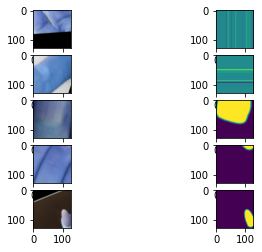

In [6]:
# 3

import numpy as np
import matplotlib.pyplot as plt


def random_rotate_image(image, label, max_angle=180):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    angle = np.random.randint(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_img = cv2.warpAffine(image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    rot_lab = cv2.warpAffine(label, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return (rot_img, rot_lab)


def get_random_crop(img, lbl, height, width):
    """Return a random crop of image"""
    max_x = img.shape[1] - width
    max_y = img.shape[0] - height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)
    return (img[y: y + height, x: x + width], 
           lbl[y: y + height, x: x + width])


def augmentation_data_iterator(
        n: int, 
        list1, 
        list2, 
        height=128, 
        width=128, 
        blur=True,
        blur_size=10,
        rotation=True,
        max_rotation_angle=180,
        mirror=True
):
    rotation_center = (height/2, width/2) 
    fit = random_data_iterator(n, list1, list2)
    while True:
        data = next(fit)
        images = []
        labels = []
        for i in range(n):
            img = cv2.imread(data[0][i]) / 255.
            lbl = cv2.imread(data[1][i], flags=cv2.IMREAD_GRAYSCALE) / 255.
            
            # Random rotate
            if rotation:
                img, lbl = random_rotate_image(img, lbl, max_rotation_angle)
            
            # Random choosing to flip horizontally
            if random.choice([True, False]):
                img = np.flip(img, axis=1)
                lbl = np.flip(lbl, axis=1)
            
            # Random choosing to flip vertically
            if random.choice([True, False]):
                img = np.flip(img, axis=0)
                lbl = np.flip(lbl, axis=0)
                
            # Random blur
            if blur:
                blur_coef = np.random.randint(1, blur_size)
                img = cv2.blur(img, (blur_coef, blur_coef))
                lbl = cv2.blur(lbl, (blur_coef, blur_coef))
            
            # Randomly cropping height x width piece from image
            img, lbl = get_random_crop(img, lbl, height, width)
            
            images.append(img)
            labels.append(lbl)
        yield images, labels


n = 5      
fit = augmentation_data_iterator(n, images, labels)
gen_data = next(fit)

for i in range(n):
    plt.subplot(n, 2, 2*i+1)
    plt.imshow(gen_data[0][i])
    
    plt.subplot(n, 2, 2*i+2)
    plt.imshow(gen_data[1][i])
    
            
plt.show()

In [8]:
np.unique(gen_data[1][0])

array([-3.45402719e-16, -1.99860624e-16, -1.23358114e-16, -9.86864911e-17,
       -7.40148683e-17, -5.01142338e-17, -4.93432455e-17, -2.47439029e-17,
       -2.46716228e-17, -1.23358114e-17, -6.16790569e-18, -1.92747053e-18,
       -1.63834995e-18, -1.40645115e-18, -4.42715887e-19, -9.63735264e-20,
       -5.11984359e-20, -4.81867632e-20, -1.20466908e-20,  0.00000000e+00,
        1.80700362e-20,  2.11118256e-18,  3.03576608e-18,  3.08395285e-18,
        6.14381231e-18,  7.32438801e-18,  1.23358114e-17,  1.47451495e-17,
        3.91878852e-17,  4.93432455e-17,  6.16911036e-17,  9.86864911e-17,
        1.11022302e-16,  1.29453739e-16,  1.46391387e-16,  1.72677266e-16,
        1.72701359e-16,  1.97372982e-16,  3.94745964e-16])

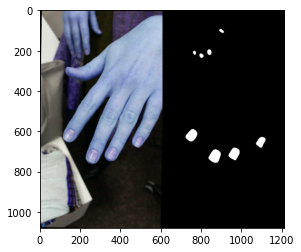

In [9]:
img, lbl = random_rotate_image(cv2.imread(images[10]), cv2.imread(labels[10]))
plt.imshow(np.concatenate((img, lbl), axis=1))
plt.show()